In [46]:
%matplotlib inline

In [47]:
from typing import Dict, Tuple, List

FileAuthors = Dict[str, int]
RepoFileAuthors = Dict[str, FileAuthors]
AllRepoFileAuthors = Dict[str, RepoFileAuthors]

# test_dict: AllRepoFileAuthors = {
#     'repo name': {
#         '/file/path': {
#             'author name': 12345  # line count
#         }
#     }
# }

In [48]:
import subprocess

def blame(file, repo_root):
    p = subprocess.run(["git", "blame", "--line-porcelain", file],
       capture_output=True,
       cwd=repo_root)

    if p.returncode != 0:
        raise IOError(p.stderr.decode("utf8"))
    return p.stdout.decode("utf8").split("\n")

def git_ls_files(repo_root, dir=None):
    args = ["git", "ls-files"]
    if dir is not None:
        args.append(dir) 
        
    p = subprocess.run(args,
       capture_output=True,
       cwd=repo_root)
    
    if p.returncode != 0:
        raise IOError(p.stderr.decode("utf8"))
    return p.stdout.decode("utf8").split("\n")

def git_log(repo_root, rev_range):
    args = ["git", "log", "--format=reference", rev_range]
    p = subprocess.run(args,
       capture_output=True,
       cwd=repo_root)

    if p.returncode != 0:
        raise IOError(p.stderr.decode(("utf8")))
    return p.stdout.decode("utf8").split("\n")

def add_lines(counts: FileAuthors, author, start, end):
    if author not in counts:
        counts[author] = 0
        
    diff = end - start
    counts[author] += diff

def count_repo(executor, repo_root, filter_func):
    counts = {}
    files = git_ls_files(repo_root=repo_root)
    for f in files:
        if filter_func(f):
            continue
        counts[f]: FileAuthors = executor.submit(count_file, f, repo_root)
    return counts

def count_file(f, repo_root):
    counts: FileAuthors = {}
    last_author_header_ln = 1
    last_header_ln = 1
    last_author_name = None

    for j, line in enumerate(blame(f, repo_root)):
        if line == "":
            continue
        header_match = header_re.match(line)
        if header_match is not None:
            header_new_ln = int(header_match.group(1))
            last_header_ln = int(header_new_ln)
            continue
        author_match = author_re.match(line)
        if author_match is not None:
            author = author_match.group(1)
            if last_author_name is None:
                last_author_name = author
                continue
            add_lines(counts, last_author_name, last_author_header_ln, last_header_ln)
            last_author_name = author
            last_author_header_ln = last_header_ln

    add_lines(counts, last_author_name, last_author_header_ln, last_header_ln + 1)
    return counts

In [49]:
from datetime import date
from math import floor
import re, time, os.path as path
from concurrent.futures import ThreadPoolExecutor, as_completed

start = time.perf_counter()

max_workers = 15
root_dir = "/home/bwhite/Projects/bryanchriswhite"
repo_names = [
    "storj",
    "uplink",
    "uplink-c"
]
author_regex = re.compile("\S+\s+\(([\w ]+)\s*?\d{4,}")
commit_re = re.compile("^(\w+)\s+\(.*,\s+(\d{4,}-\d{2,}-\d{2,})\)$")
header_re = re.compile("\w{,40} \d+ (\d+)(:? (\d+))?")
author_re = re.compile("author (.+)$")
excluded_exts = set()
repo_counts: AllRepoFileAuthors = {}

def filter_files(filename):
    ext = path.splitext(filename)[1]
    ext_whitelist = (
        ".go", ".proto", ".c", ".h", ".sh", ".md", ".xml", ".wixproj", ".wsx", ".cs"
    )
    exclude = filename == "" or ext not in ext_whitelist
    
    if exclude:
        excluded_exts.add(ext)
    
    return exclude

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    results = {}
    for name in repo_names:
        repo_root = path.join(root_dir, name)
        results[name] = count_repo(executor, repo_root, filter_files)

    for name, future in results.items():
        repo_counts[name] = {k: v.result() for k, v in future.items()}

end = time.perf_counter()
print(str.format("done: {}s!", round(end - start, 2)))
print(str.format("excluded file extensions: {}", excluded_exts))

done: 10.35s!
excluded file extensions: {'', '.jpg', '.ico', '.pro', '.sum', '.tmpl', '.pem', '.jar', '.rtf', '.bmp', '.java', '.sql', '.scss', '.pdf', '.sln', '.csproj', '.gif', '.public', '.png', '.cert', '.yaml', '.json', '.py', '.wxs', '.bat', '.ts', '.key', '.pom', '.html', '.properties', '.mod', '.dbx', '.ttf', '.js', '.svg', '.css', '.csv', '.gradle', '.snap', '.lock', '.vue', '.config', '.service', '.zip'}


In [50]:
max_samples = 128
samples: List[Tuple[date, str]] = []
commits: Dict[str, date] = {}
log_lines = git_log(path.join(root_dir, repo_names[2]), "master")
for line in log_lines:
    if line == "":
        continue

    match = commit_re.match(line)
    if match is None:
        continue

    commit_hash, commit_date = [match[k] for k in (range(1, 3))]

    if commit_hash is None or commit_date is None:
        print("no commit hash or date")
        continue

    commits[commit_hash] = date.fromisoformat(commit_date)

date_hashes: List[Tuple[date, str]] = [(d, h) for h, d in commits.items()]
date_hashes.sort(key=lambda n: n[0], reverse=True)

date_hashes_len = len(date_hashes)
if max_samples > date_hashes_len:
    max_samples = date_hashes_len

interval = floor(len(date_hashes) / max_samples)

for i, date_hash in enumerate(date_hashes):
    if i % interval == 0:
        samples.append(date_hash)

max_worktrees = 10

In [51]:
from queue import SimpleQueue

class WorktreeQueue:
    __base_cmd: List[str] = ['git', 'worktree']

    def __init__(self, repo_root: str, max_worktrees: int):
        self.__repo_root = repo_root
        self.__max = max_worktrees

    def __enter__(self):
        # init queue
        self.__q = SimpleQueue()

        # set up n workers with loop
        # workers pull from queue

        # for i in range(0, self.__max):
            # self.add_worktree(f'worktree{i}', 'master')
            # self.move_worktree(f'worktree{i}', '')
        return self

    def __exit__(self, type, value, tb):
        for i in range(0, self.__max):
            self.remove_worktree(f'worktree{i}')

    def __git(self, cmd: str, *args: str):
        p = subprocess.run(self.__base_cmd +
                           [cmd, *args],
                           capture_output=True,
                           cwd=self.__repo_root)
        if p.returncode != 0:
            raise IOError(p.stderr)
        return p

    def add_worktree(self, path: str, hash: str):
        self.__git('add', path, hash)

    def remove_worktree(self, path: str):
        self.__git('remove', path)

    def get_root(self):
        return self.__repo_root

from time import sleep
# with WorktreeQueue("/home/bwhite/Projects/bryanchriswhite/uplink", 10) as q:
#     for 
    
    # print(q.get_root())
    # sleep(2)


In [52]:
# def add_worktree(i: int):
#     work_path = path.join(f'worktree{i}')
#     args = ["git", "worktree", "add", work_path, "master"]
#     subprocess.run(args,
#                    capture_output=True,
#                    cwd=root_dir)
# 
# for i in range(0, max_worktrees):
#     add_worktree(i)
# 
# for i in range(0, max_worktrees):
#     remove_worktree(i)

# for c_date, hash in samples:
    #git worktree move


In [53]:
totals: Dict[str, Dict[str, int]] = {}
total_lines: Dict[str, int] = {}
to_percent = lambda n, total: round((n / total) * 100, 2)

for repo, files_author_line_counts in repo_counts.items():
    repo_totals: Dict[str, int] = {}
    total_lines[repo] = 0
            
    for author_line_counts in files_author_line_counts.values():
        for author, counts in author_line_counts.items():
            total_lines[repo] += counts
            
            if author not in repo_totals:
                repo_totals[author] = 0
            repo_totals[author] += counts
    totals[repo] = repo_totals
        
def print_totals(t):
    for i, author, total, pct in t:
        print(str.format("#{}: {} ({}% | {})", i, author, pct, total))

                                    #           rank name count pct
RepoAuthorTotals = List[List[any]]  # List[List[int, str, int, float]]

totals_to_graph: Dict[str, RepoAuthorTotals] = {}
for repo, totals in totals.items():
    total_list: List[Tuple[int, str, float]] = [(*tup, to_percent(tup[1], total_lines[repo])) for tup in totals.items()]
    total_list.sort(key=lambda x: x[1], reverse=True)
    total_list: RepoAuthorTotals = [[i+1, *tup] for i, tup in enumerate(total_list)]
    
    totals_to_graph[repo] = total_list

    print(repo)
    print_totals(total_list[:10])
    print()


storj
#1: Egon Elbre (14.95% | 24772)
#2: paul cannon (9.17% | 15203)
#3: Michal Niewrzal (6.96% | 11536)
#4: Jeff Wendling (6.66% | 11042)
#5: Yaroslav Vorobiov (6.62% | 10977)
#6: Isaac Hess (4.81% | 7975)
#7: Bryan White (4.6% | 7626)
#8: Yingrong Zhao (3.44% | 5700)
#9: Maximillian von Briesen (3.03% | 5020)
#10: Natalie Villasana (2.91% | 4820)

uplink
#1: Kaloyan Raev (31.97% | 3608)
#2: Egon Elbre (25.52% | 2881)
#3: Michal Niewrzal (22.86% | 2580)
#4: JT Olio (4.61% | 520)
#5: Ivan Fraixedes (2.49% | 281)
#6: Maximillian von Briesen (2.04% | 230)
#7: Jeff Wendling (1.9% | 214)
#8: Natalie Villasana (1.51% | 170)
#9: ccase (1.28% | 145)
#10: Jess G (0.89% | 101)

uplink-c
#1: Egon Elbre (85.13% | 2593)
#2: Michal Niewrzal (12.34% | 376)
#3: Kaloyan Raev (2.53% | 77)



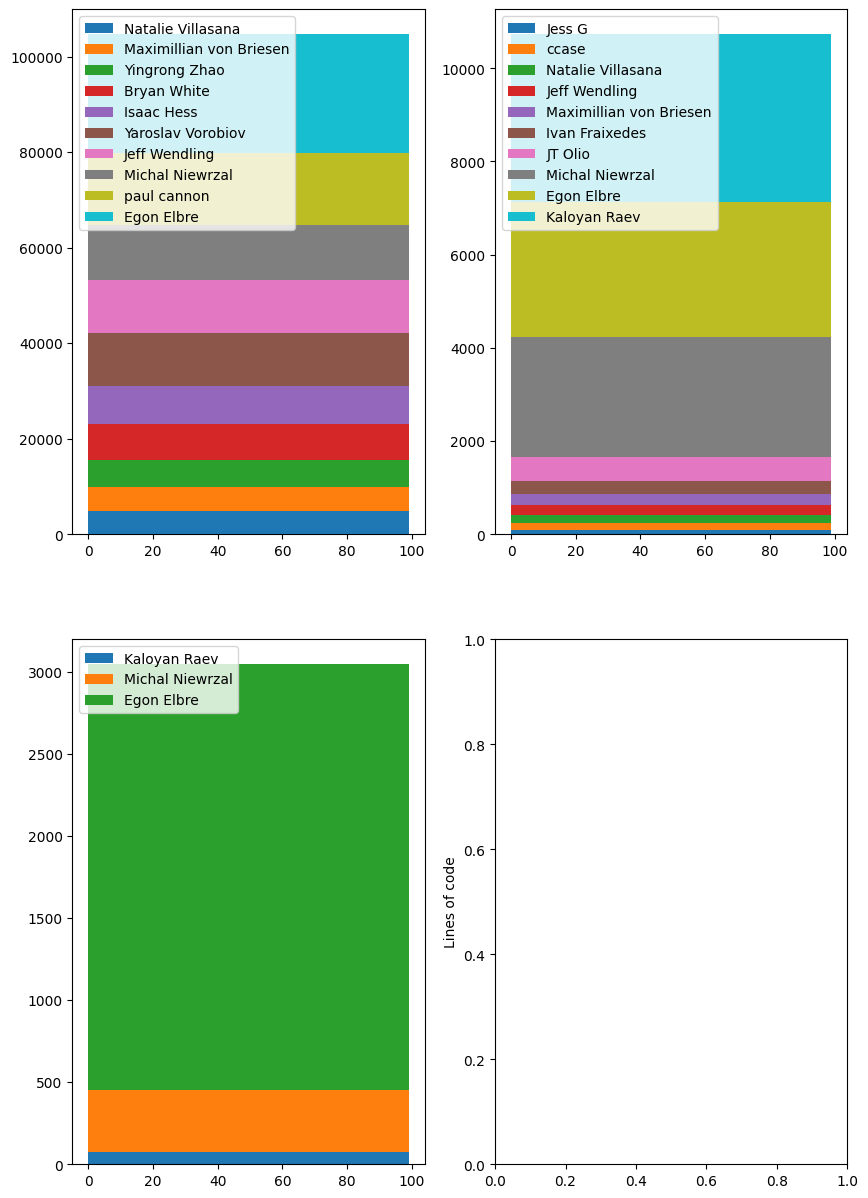

In [57]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor

nrows = 2
fig, ax = plt.subplots(nrows, ceil(len(repo_names) / nrows), figsize=(10,15))
plt.ylabel('Lines of code')
subplt_i = 0

# TODO: add time
x = np.arange(100)
# x = np.array([])

for repo, total_list in totals_to_graph.items():
    i = floor(subplt_i / 2)
    j = subplt_i % 2

    total_list = total_list[:10]
    total_list.reverse()

    ys = [n[2] for n in total_list]
    labels = [n[1] for n in total_list]

    ax[i,j].stackplot(x, *ys, labels=labels)
    ax[i,j].legend(loc='upper left')

    subplt_i += 1
plt.show()

In [55]:
# from github import Github
#
# apikey = open("github.apikey")
#
# g = Github()
# org = g.get_organization("storj")
# repos = org.get_repos()
# page = repos.get_page(0)
#
# storj_repos = page

In [56]:
# [(r.name, r.created_at) for r in storj_repos]